In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.callbacks import EarlyStopping

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


# Load data

In [4]:
# Load merged training data (normalized)
import pandas as pd

df = pd.read_csv('NewData/merged_train.csv')

print("Data shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Ensure a numeric time column is available
if 'Time' in df.columns:
    try:
        df['time_seconds'] = pd.to_timedelta(df['Time']).dt.total_seconds()
    except Exception:
        df['time_seconds'] = pd.to_numeric(df['Time'], errors='coerce').fillna(0.0)
elif 'time_seconds' not in df.columns:
    df['time_seconds'] = 0.0

# Quick peek
df.head()

Data shape: (32222, 33)

Columns: ['Point_ID', 'Year', 'Track', 'Session', 'Driver', 'Lap_Time', 'Time', 'Distance', 'X', 'Y', 'Speed', 'Throttle', 'Brake', 'nGear', 'RPM', 'DRS', 'X_norm', 'Y_norm', 'trk_match_dist', 'trk_x_m', 'trk_y_m', 'trk_left_x_m', 'trk_left_y_m', 'trk_right_x_m', 'trk_right_y_m', 'trk_left_x_norm', 'trk_left_y_norm', 'trk_right_x_norm', 'trk_right_y_norm', 'trk_curvature', 'trk_centroid_x_norm', 'trk_centroid_y_norm', 'tire_wear']


,Point_ID,Year,Track,Session,Driver,Lap_Time,Time,Distance,X,Y,...,trk_right_y_m,trk_left_x_norm,trk_left_y_norm,trk_right_x_norm,trk_right_y_norm,trk_curvature,trk_centroid_x_norm,trk_centroid_y_norm,tire_wear,time_seconds
0,2018_Budapest_Q_VET_1,2018,Budapest,Q,VET,00:01:16.666000,0 days 00:00:00,0.266667,-86.904435,-61.332845,...,-4.657720,0.498245,0.082182,0.484044,0.066956,0.060680,0.491144,0.074569,0.034895,0.000
1,2018_Budapest_Q_VET_2,2018,Budapest,Q,VET,00:01:16.666000,0 days 00:00:00.040000,3.334915,-90.700000,-58.200000,...,-4.364222,0.494662,0.084817,0.480457,0.069593,0.034450,0.487559,0.077205,0.019936,0.040
2,2018_Budapest_Q_VET_3,2018,Budapest,Q,VET,00:01:16.666000,0 days 00:00:00.280000,21.966667,-115.547753,-37.706121,...,-2.604899,0.473142,0.100635,0.458951,0.085401,0.051289,0.466047,0.093018,0.030806,0.280
3,2018_Budapest_Q_VET_4,2018,Budapest,Q,VET,00:01:16.666000,0 days 00:00:00.340000,26.690815,-121.600000,-32.700000,...,-2.019190,0.465963,0.105903,0.451779,0.090664,0.044268,0.458871,0.098284,0.026876,0.340
4,2018_Budapest_Q_VET_5,2018,Budapest,Q,VET,00:01:16.666000,0 days 00:00:00.519000,40.887500,-138.382712,-18.760780,...,-0.848518,0.451598,0.116431,0.437428,0.101183,0.026751,0.444513,0.108807,0.016766,0.519


In [5]:
print(df.isnull().sum())
print(df.describe())

Point_ID               0
Year                   0
Track                  0
Session                0
Driver                 0
Lap_Time               0
Time                   0
Distance               0
X                      0
Y                      0
Speed                  0
Throttle               0
Brake                  0
nGear                  0
RPM                    0
DRS                    0
X_norm                 0
Y_norm                 0
trk_match_dist         0
trk_x_m                0
trk_y_m                0
trk_left_x_m           0
trk_left_y_m           0
trk_right_x_m          0
trk_right_y_m          0
trk_left_x_norm        0
trk_left_y_norm        0
trk_right_x_norm       0
trk_right_y_norm       0
trk_curvature          0
trk_centroid_x_norm    0
trk_centroid_y_norm    0
tire_wear              0
time_seconds           0
dtype: int64
               Year      Distance             X             Y         Speed  \
count  32222.000000  32222.000000  32222.000000  32222.000

In [6]:
# Feature configuration: use normalized track features + tire_wear as inputs; outputs are normalized positions and time
input_features = ['trk_centroid_x_norm','trk_centroid_y_norm','trk_right_x_norm','trk_right_y_norm','trk_left_x_norm','trk_left_y_norm','tire_wear']
output_features = ['X_norm','Y_norm','time_seconds']
seq_length = 600  # target sequence length for sliding-window generation

# Create RNN Sequences

In [7]:
def create_sequences_by_id(data, seq_len, input_features, output_features):
    """Create sequences grouped by lap identifier using Point_ID prefix rule.

    - Lap id is everything before the final underscore+integer in Point_ID.
    - Each lap is sorted by Distance (preferred) or time_seconds if Distance missing.
    - Sliding windows of length seq_len are emitted; target y is the step immediately after the window.
    """
    data = data.copy()
    data["Point_Base"] = data["Point_ID"].astype(str).str.rsplit("_", n=1).str[0]

    X, y = [], []

    for _, group in data.groupby("Point_Base"):
        # prefer sorting by Distance, otherwise time_seconds, else Point_ID order
        if 'Distance' in group.columns:
            group = group.sort_values('Distance').reset_index(drop=True)
        elif 'time_seconds' in group.columns:
            group = group.sort_values('time_seconds').reset_index(drop=True)
        else:
            group = group.sort_values('Point_ID').reset_index(drop=True)

        n = len(group)
        if n <= seq_len:
            # skip laps shorter than or equal to seq_len (no next-step target)
            continue

        # sliding window
        for i in range(n - seq_len):
            X.append(group[input_features].iloc[i:i+seq_len].values.astype(float))
            y.append(group[output_features].iloc[i+seq_len].values.astype(float))

    if len(X) == 0:
        return np.empty((0, seq_len, len(input_features))), np.empty((0, len(output_features)))

    return np.array(X), np.array(y)

In [8]:
X, y = create_sequences_by_id(df, seq_length, input_features, output_features)

print(f"Sequence shapes:")
print(f"Input (X): {X.shape}")
print(f"Output (y): {y.shape}")

Sequence shapes:
Input (X): (4258, 600, 7)
Output (y): (4258, 3)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 3406 samples
Test set: 852 samples


In [10]:
input_scaler = StandardScaler()
output_scaler = StandardScaler()

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled = input_scaler.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(X_train.shape)

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = input_scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# Convert the 'Time' column (index 2) of y_train to total seconds (float)
y_train_processed = y_train.copy()
y_train_processed[:, 2] = np.array([pd.to_timedelta(t).total_seconds() for t in y_train_processed[:, 2]])
y_train_processed = y_train_processed.astype(float) # Ensure all elements are float

# Convert the 'Time' column (index 2) of y_test to total seconds (float)
y_test_processed = y_test.copy()
y_test_processed[:, 2] = np.array([pd.to_timedelta(t).total_seconds() for t in y_test_processed[:, 2]])
y_test_processed = y_test_processed.astype(float) # Ensure all elements are float

y_train_scaled = output_scaler.fit_transform(y_train_processed)
y_test_scaled = output_scaler.transform(y_test_processed)

# Train Model

In [11]:
model = keras.Sequential([
    keras.layers.LSTM(64, return_sequences=True,
                      input_shape=(seq_length, len(input_features)),
                      name='lstm_1'),
    keras.layers.Dropout(0.2, name='dropout_1'),

    keras.layers.LSTM(32, return_sequences=False, name='lstm_2'),
    keras.layers.Dropout(0.2, name='dropout_2'),

    keras.layers.Dense(32, activation='relu', name='dense_1'),
    keras.layers.Dense(len(output_features), name='output')
])

print("Model Architecture:")
model.summary()

Model Architecture:


c:\Users\reeka\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 600, 64)        │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 600, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,003 (125.01 KB)

 Trainable params: 32,003 (125.01 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - loss: 0.1238 - mae: 0.2315 - val_loss: 0.0172 - val_mae: 0.0939
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - loss: 0.1238 - mae: 0.2315 - val_loss: 0.0172 - val_mae: 0.0939
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - loss: 0.0269 - mae: 0.1178 - val_loss: 0.0080 - val_mae: 0.0585
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - loss: 0.0269 - mae: 0.1178 - val_loss: 0.0080 - val_mae: 0.0585
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - loss: 0.0202 - mae: 0.1015 - val_loss: 0.0048 - val_mae: 0.0495
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - loss: 0.0202 - mae: 0.1015 - val_loss: 0.0048 - val_mae: 0.0495
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - loss: 0.0168 - mae: 0.0914 - val_loss: 0.0041 - val_mae: 0.0442
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - loss: 0.0168 - mae: 0.0914 - val_loss: 0.0041 - val_mae: 0.0442
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/

In [14]:
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print(f"\nTest Results:")
print(f"  Loss (MSE): {test_loss:.4f}")
print(f"  MAE: {test_mae:.4f}")


Test Results:
  Loss (MSE): 0.0017
  MAE: 0.0290


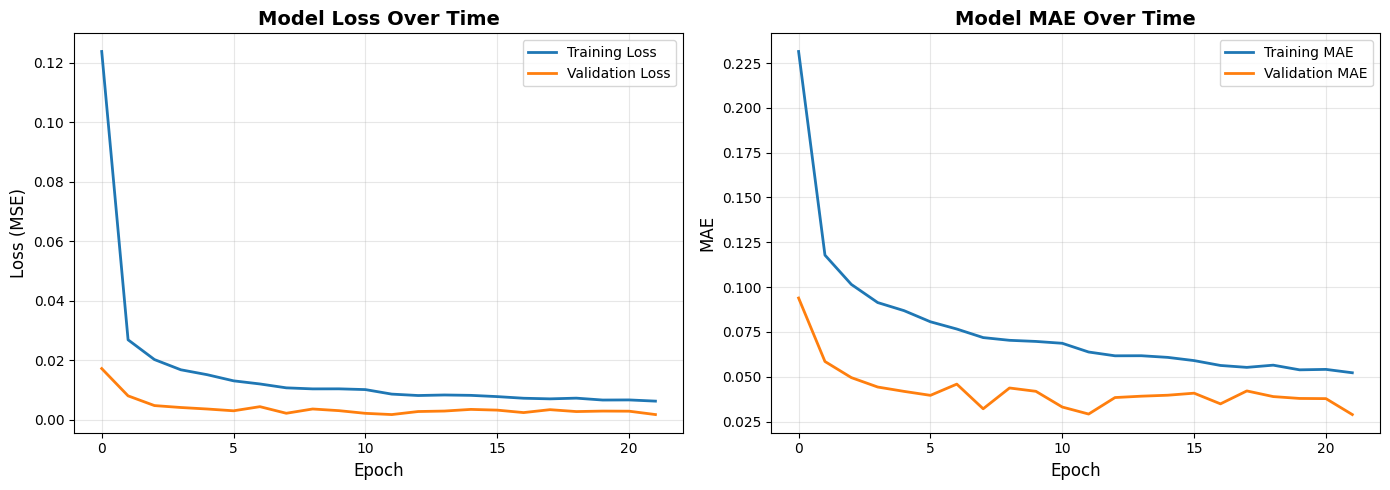

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Model MAE Over Time', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

In [16]:
y_pred_scaled = model.predict(X_test_scaled, verbose=0)
y_pred = output_scaler.inverse_transform(y_pred_scaled)

print(f"Generated {len(y_pred)} predictions")
print(f"\nSample prediction:")
print(f"  X: {y_pred[0, 0]:.2f} m")
print(f"  Y: {y_pred[0, 1]:.2f} m")
print(f"  Time: {y_pred[0, 2]:.2f} s")

Generated 852 predictions

Sample prediction:
  X: 0.39 m
  Y: 0.75 m
  Time: 0.01 s


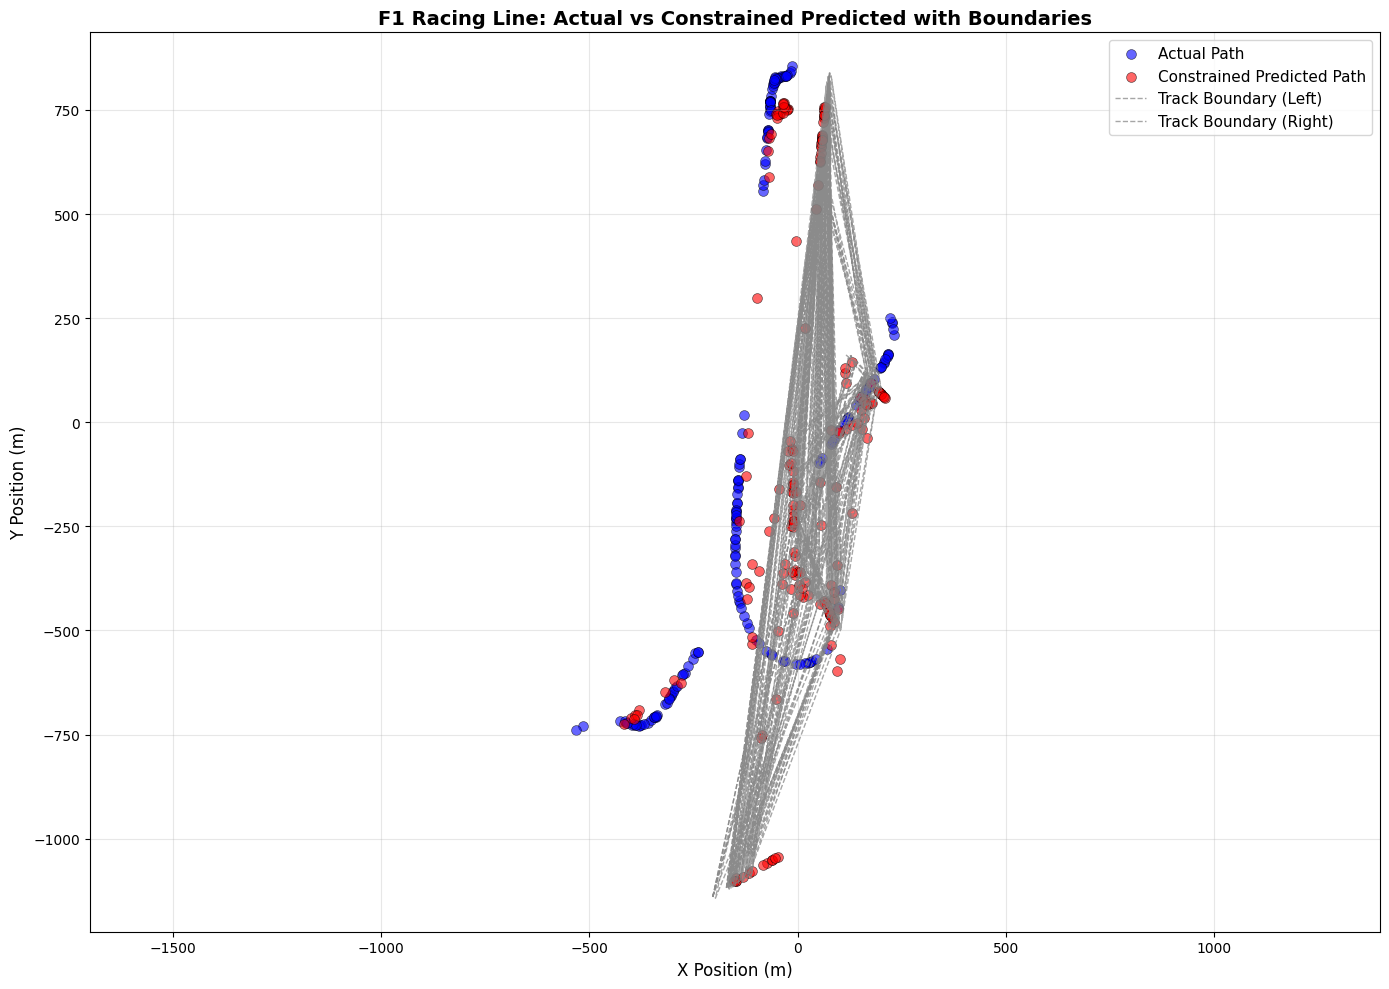

✓ Racing line comparison with constrained predictions and boundaries saved to 'racing_line_constrained_comparison.png'


In [31]:
sample_idx = 0
sample_size = len(y_test) # Use all available test samples for visualization

# Prepare lists to store track boundaries for plotting
track_left_x_points = []
track_left_y_points = []
track_right_x_points = []
track_right_y_points = []

# Iterate through each test sample to get boundaries corresponding to each predicted point
for i in range(sample_size):
    # Extract the last two timesteps from the input sequence X_test[i]
    # These timesteps provide the context (track centerline, widths, and orientation)
    # for the track boundaries at the point where the prediction is made.
    last_two_timesteps_for_boundaries = X_test[i][-2:]

    # Retrieve track boundary information and normal vector for the current point
    (track_x_m, track_y_m, w_tr_left_m, w_tr_right_m, norm_vec_x, norm_vec_y) = \
        get_track_boundaries_for_prediction(last_two_timesteps_for_boundaries)

    # Calculate left and right boundary coordinates for the current track point
    track_left_x_points.append(track_x_m + w_tr_left_m * norm_vec_x)
    track_left_y_points.append(track_y_m + w_tr_left_m * norm_vec_y)
    track_right_x_points.append(track_x_m - w_tr_right_m * norm_vec_x)
    track_right_y_points.append(track_y_m - w_tr_right_m * norm_vec_y)


plt.figure(figsize=(14, 10))

# Plot Actual Path as a line
plt.plot(y_test[sample_idx:sample_idx+sample_size, 0],
            y_test[sample_idx:sample_idx+sample_size, 1],
            c='blue', label='Actual Path', alpha=0.6, linewidth=2)

# Plot Constrained Predicted Path as a line
plt.plot(y_pred_constrained[sample_idx:sample_idx+sample_size, 0],
            y_pred_constrained[sample_idx:sample_idx+sample_size, 1],
            c='red', label='Constrained Predicted Path', alpha=0.6, linewidth=2)

# Plot Track Boundaries (these will be individual points forming lines, corresponding to each prediction)
plt.plot(track_left_x_points, track_left_y_points, color='gray', linestyle='--', linewidth=1, label='Track Boundary (Left)', alpha=0.7)
plt.plot(track_right_x_points, track_right_y_points, color='gray', linestyle='--', linewidth=1, label='Track Boundary (Right)', alpha=0.7)

plt.xlabel('X Position (m)', fontsize=12)
plt.ylabel('Y Position (m)', fontsize=12)
plt.title('F1 Racing Line: Actual vs Constrained Predicted with Boundaries', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.savefig('racing_line_constrained_comparison.png', dpi=150)
plt.show()

print("✓ Racing line comparison with constrained predictions and boundaries saved to 'racing_line_constrained_comparison.png'")

In [20]:
model.save('f1_racing_line_model.h5')

with open('input_scaler.pkl', 'wb') as f:
    pickle.dump(input_scaler, f)

with open('output_scaler.pkl', 'wb') as f:
    pickle.dump(output_scaler, f)


✓ Model saved to 'f1_racing_line_model.h5'
✓ Scalers saved to 'input_scaler.pkl' and 'output_scaler.pkl'
